---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [3]:
import os
print("Current path:", os.getcwd())
print("Files and folders here:", os.listdir())


Current path: /home/ubuntu/lab08-RitusriMohan
Files and folders here: ['.gitignore', 'lab08-yourname_files', '.github', 'lightcast_job_postings.csv', '.venv', '_output', 'requirements.txt', '.ipynb_checkpoints', 'data', 'lab08-RitusriMohan.ipynb', 'README.md', 'lab08-yourname.html', '.git']


In [4]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true")\
    .option("inferSchema", "true")\
    .option("multiLine", "true")\
    .option("escape", "\"")\
    .csv("lightcast_job_postings.csv")


# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

25/04/14 18:56:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Selecting useful columns
cols_to_use = ["SALARY", "MIN_YEARS_EXPERIENCE", "DURATION", "EMPLOYMENT_TYPE_NAME"]
df_selected = df.select(cols_to_use).dropna()

# Encode categorical column
indexer = StringIndexer(inputCol="EMPLOYMENT_TYPE_NAME", outputCol="EMPLOYMENT_TYPE_IDX", handleInvalid="skip")
encoder = OneHotEncoder(inputCol="EMPLOYMENT_TYPE_IDX", outputCol="EMPLOYMENT_TYPE_VEC")

# Assemble features
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "DURATION", "EMPLOYMENT_TYPE_VEC"],
    outputCol="features"
)

# Pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])
data_prepared = pipeline.fit(df_selected).transform(df_selected)

# Final check
data_prepared.select("features", "SALARY").show(5, truncate=False)


+-------------------+------+
|features           |SALARY|
+-------------------+------+
|[6.0,55.0,1.0,0.0] |192800|
|[12.0,18.0,1.0,0.0]|125900|
|[5.0,20.0,1.0,0.0] |118560|
|[6.0,55.0,1.0,0.0] |192800|
|[12.0,16.0,1.0,0.0]|116500|
+-------------------+------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [8]:
#| eval: true
#| echo: false
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(11604, 7)


[Stage 10:>                                                         (0 + 1) / 1]

(2812, 7)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [9]:
# Import the required library
from pyspark.ml.regression import LinearRegression

# Set the features column
feature_names = assembler.getInputCols()

# Initialize and fit the model on training data
lr = LinearRegression(featuresCol="features", labelCol="SALARY")
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Optional: Print diagnostics (for debugging, not for final submission)
print("\n---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(feature_names))
print("Length of coefs:", len([lr_model.intercept] + lr_model.coefficients))
print("Length of se:", len(summary.coefficientStandardErrors))
print("Length of tvals:", len(summary.tValues))
print("Length of pvals:", len(summary.pValues))


25/04/14 19:32:24 WARN Instrumentation: [851e8752] regParam is zero, which might cause numerical instability and overfitting.
[Stage 14:>                                                         (0 + 1) / 1]


---This is Diagnostic check, No need to print it in the final doc---
Length of features: 3
Length of coefs: 4
Length of se: 5
Length of tvals: 5
Length of pvals: 5


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [18]:
import pandas as pd

# Align lists manually
features = ["Intercept"] + feature_names
coefs = [lr_model.intercept] + list(lr_model.coefficients)

# Pad coefs if needed
while len(coefs) < 5:
    coefs.append(None)

# Pad feature names if needed
while len(features) < 5:
    features.append(None)

# Convert others to lists if not already
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

# Create the DataFrame
coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": se,
    "T-stat": tvals,
    "P-value": pvals
})

# Print summary
print("--- Summary Table ---")
print(coef_table.to_string(index=False))


--- Summary Table ---
             Feature     Estimate   Std Error    T-stat  P-value
           Intercept 82033.830092  102.108731 66.565946 0.000000
MIN_YEARS_EXPERIENCE  6796.964269   23.512401 -0.687152 0.492001
            DURATION   -16.156599 2953.962216  0.374743 0.707859
 EMPLOYMENT_TYPE_VEC  1106.976203 3581.555728 -0.421511 0.673390
                None -1509.665203 2985.455723 27.477825 0.000000


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


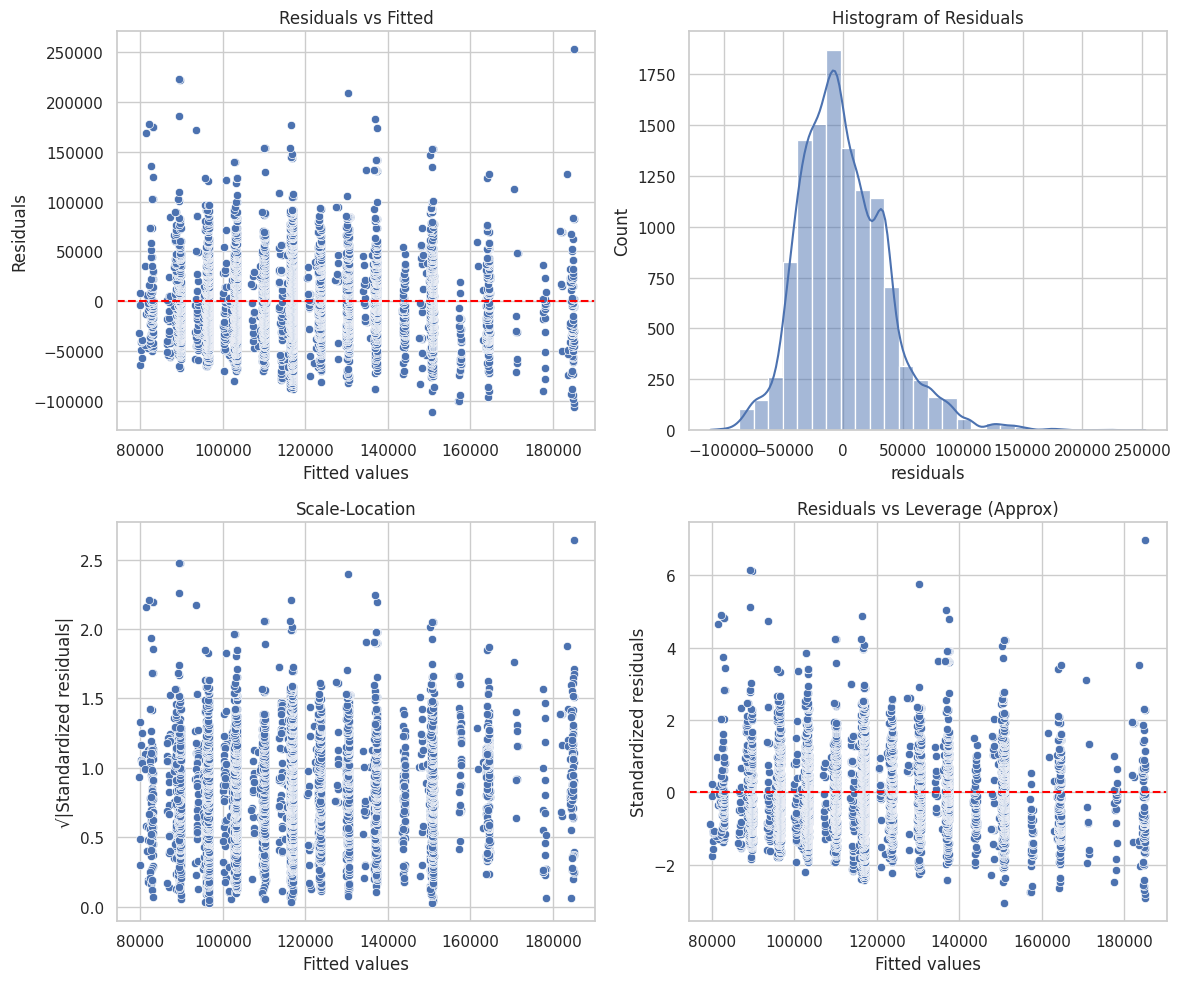

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load predictions from the GLR model
df_pred = summary.predictions.select("prediction", "SALARY")
df_pred = df_pred.withColumn("residuals", df_pred["SALARY"] - df_pred["prediction"])

# Convert to pandas
pdf = df_pred.toPandas()
pdf["fitted"] = pdf["prediction"]

# Standardized residuals
res_mean = np.mean(pdf["residuals"])
res_std = np.std(pdf["residuals"])
pdf["std_residuals"] = (pdf["residuals"] - res_mean) / res_std
pdf["sqrt_std_resid"] = np.sqrt(np.abs(pdf["std_residuals"]))

# Set up plot
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")

# 1. Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x=pdf["fitted"], y=pdf["residuals"])
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

# 2. Histogram of Residuals
plt.subplot(2, 2, 2)
sns.histplot(pdf["residuals"], bins=30, kde=True)
plt.title("Histogram of Residuals")

# 3. Scale-Location Plot
plt.subplot(2, 2, 3)
sns.scatterplot(x=pdf["fitted"], y=pdf["sqrt_std_resid"])
plt.title("Scale-Location")
plt.xlabel("Fitted values")
plt.ylabel("√|Standardized residuals|")

# 4. Residuals vs Standardized Residuals
plt.subplot(2, 2, 4)
sns.scatterplot(x=pdf["fitted"], y=pdf["std_residuals"])
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Leverage (Approx)")
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")

plt.tight_layout()
plt.show()


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg

# Predict on the test data
pred_glr = lr_model.transform(test_data)

# R² using evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SALARY", metricName="r2")
r2_eval = evaluator.evaluate(pred_glr)

# RMSE using evaluator
rmse_eval = RegressionEvaluator(predictionCol="prediction", labelCol="SALARY", metricName="rmse")
rmse = rmse_eval.evaluate(pred_glr)

# Print results
print("\n--- Evaluation Metrics ---")
print(f"R² (test data): {r2_eval:.4f}")
print(f"RMSE (test data): {rmse:.2f}")



[Stage 18:>                                                         (0 + 1) / 1]


--- Evaluation Metrics ---
R² (test data): 0.2752
RMSE (test data): 35410.90


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

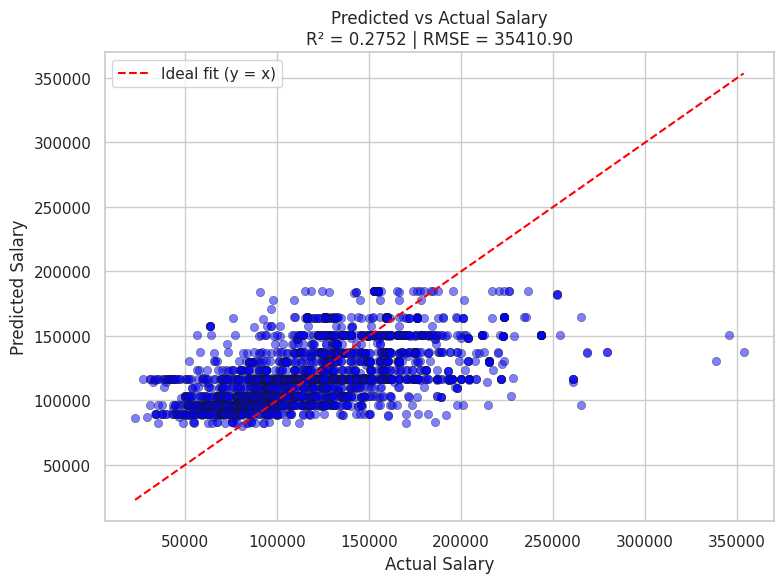

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark predictions to Pandas
pandas_df = pred_glr.select("SALARY", "prediction").toPandas()

# Plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")

sns.scatterplot(data=pandas_df, x="SALARY", y="prediction", alpha=0.5, color="blue", edgecolor="k")
plt.plot([pandas_df["SALARY"].min(), pandas_df["SALARY"].max()],
         [pandas_df["SALARY"].min(), pandas_df["SALARY"].max()],
         color="red", linestyle="--", label="Ideal fit (y = x)")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title(f"Predicted vs Actual Salary\nR² = {r2_eval:.4f} | RMSE = {rmse:.2f}")
plt.legend()
plt.tight_layout()

# Save the figure (optional)
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)

# Show the plot
plt.show()


In [24]:
import os
os.makedirs("_output", exist_ok=True) 

In [25]:
for i in plt.get_fignums():
    fig = plt.figure(i)
    fig.savefig(f"_output/figure_{i}.png", dpi=300, bbox_inches='tight')


# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
